# Setup the Env

In [1]:
import sys
import os

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/rachel


# Import Libraries

In [2]:
# standard libraries
import pickle
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
#!pip install seaborn -q
import seaborn as sns

# model
import tensorflow as tf

# cosine
from scipy.spatial.distance import pdist, squareform

2024-07-24 02:44:27.304675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Dataset

In [3]:
with open('/home/sagemaker-user/capstone-2024-summer/data/crsp_rachel_dict.pkl', 'rb') as file:
  merged_dict = pickle.load(file)

In [4]:
train_numerical_x = merged_dict['train_dict']['numerical_x']
train_categorical_x = merged_dict['train_dict']['categorical_x']
train_y = merged_dict['train_dict']['y']

print("---- training data ----")
print("--> num_numerical_features:", len(train_numerical_x.keys()))
for key in train_numerical_x.keys():
  print(key, train_numerical_x[key].shape)
print("--> num_categorical_features:", len(train_categorical_x.keys()))
for key in train_categorical_x.keys():
  print(key, train_categorical_x[key].shape)
print("--> target_shape:", train_y['y'].shape)

---- training data ----
--> num_numerical_features: 19
return_scaled (219323, 128, 1)
shares_outstanding_scaled (219323, 128, 1)
num_trades_scaled (219323, 128, 1)
volume_scaled (219323, 128, 1)
close_price_scaled (219323, 128, 1)
market_cap_scaled (219323, 128, 1)
volatility_7_scaled (219323, 128, 1)
sector_weighted_avg_return_scaled (219323, 128, 1)
sector_simple_avg_return_scaled (219323, 128, 1)
day_of_week_x (219323, 128, 1)
day_of_week_y (219323, 128, 1)
day_of_month_x (219323, 128, 1)
day_of_month_y (219323, 128, 1)
day_of_year_x (219323, 128, 1)
day_of_year_y (219323, 128, 1)
month_of_year_x (219323, 128, 1)
month_of_year_y (219323, 128, 1)
week_of_year_x (219323, 128, 1)
week_of_year_y (219323, 128, 1)
--> num_categorical_features: 4
permno_id (219323, 1)
company_name (219323, 1)
primary_exchange (219323, 1)
naics_sector (219323, 1)
--> target_shape: (219323, 1)


In [5]:
val_numerical_x = merged_dict['val_dict']['numerical_x']
val_categorical_x = merged_dict['val_dict']['categorical_x']
val_y = merged_dict['val_dict']['y']

print("---- validation data ----")
print("--> num_numerical_features:", len(val_numerical_x.keys()))
for key in val_numerical_x.keys():
  print(key, val_numerical_x[key].shape)
print("--> num_categorical_features:", len(val_categorical_x.keys()))
for key in val_categorical_x.keys():
  print(key, val_categorical_x[key].shape)
print("--> target_shape:", val_y['y'].shape)

---- validation data ----
--> num_numerical_features: 19
return_scaled (49498, 128, 1)
shares_outstanding_scaled (49498, 128, 1)
num_trades_scaled (49498, 128, 1)
volume_scaled (49498, 128, 1)
close_price_scaled (49498, 128, 1)
market_cap_scaled (49498, 128, 1)
volatility_7_scaled (49498, 128, 1)
sector_weighted_avg_return_scaled (49498, 128, 1)
sector_simple_avg_return_scaled (49498, 128, 1)
day_of_week_x (49498, 128, 1)
day_of_week_y (49498, 128, 1)
day_of_month_x (49498, 128, 1)
day_of_month_y (49498, 128, 1)
day_of_year_x (49498, 128, 1)
day_of_year_y (49498, 128, 1)
month_of_year_x (49498, 128, 1)
month_of_year_y (49498, 128, 1)
week_of_year_x (49498, 128, 1)
week_of_year_y (49498, 128, 1)
--> num_categorical_features: 4
permno_id (49498, 1)
company_name (49498, 1)
primary_exchange (49498, 1)
naics_sector (49498, 1)
--> target_shape: (49498, 1)


# Prepare the data for modeling

### Train

In [6]:
training_features = np.concatenate(list(train_numerical_x.values()), axis=-1)
training_features.shape

(219323, 128, 19)

In [7]:
training_permno = train_categorical_x['permno_id']
training_cnam = train_categorical_x['company_name']
training_pxch = train_categorical_x['primary_exchange']
training_sctr = train_categorical_x['naics_sector']

training_permno.shape

(219323, 1)

In [8]:
training_y = train_y['y']

training_y.shape

(219323, 1)

### Val

In [9]:
validation_features = np.concatenate(list(val_numerical_x.values()), axis=-1)
validation_features.shape

(49498, 128, 19)

In [10]:
validation_permno = val_categorical_x['permno_id']
validation_cnam = val_categorical_x['company_name']
validation_pxch = val_categorical_x['primary_exchange']
validation_sctr = val_categorical_x['naics_sector']

validation_permno.shape

(49498, 1)

In [11]:
validation_y = val_y['y']

validation_y.shape

(49498, 1)

# Define visualization function to visualize the training progression

In [12]:
def visualize(model_history):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  # visualize the loss
  axes[0].plot(model_history.history['loss'], color='purple', label='train_losses')
  axes[0].plot(model_history.history['val_loss'], color='orange', label='val_losses')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss Progression')
  axes[0].legend()

  # visualize the RMSE
  axes[1].plot(model_history.history['root_mean_squared_error'], color='purple', label='train_RMSE')
  axes[1].plot(model_history.history['val_root_mean_squared_error'], color='orange', label='val_RMSE')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('RMSE')
  axes[1].set_title('RMSE Progression')
  axes[1].legend()

  plt.show()

# Build the model

In [13]:
EMBED_DIM = 200

In [14]:
def build_model(features,
                permno_features,
                initial_learning_rate=0.001,
                decay_steps=1000,
                decay_rate=0.96,
                attn_hidden=[128,64,32],
                embed_hidden=[64,32],
                hidden=[64,32],
                dropout=0.2):

  tf.keras.backend.clear_session()

  # set return features input layer
  return_features = tf.keras.layers.Input(shape=(features.shape[1],features.shape[2]), name='return_features') #[batch_size, num_days, num_features]

  # set permno features input layer
  permnos = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='permnos')
  permno_binned = tf.keras.layers.StringLookup(vocabulary=np.unique(permno_features))(permnos)
  permno_embeddings = tf.keras.layers.Embedding(input_dim=(len(np.unique(permno_features))+1), output_dim=EMBED_DIM, input_length=1, name='embeddings')(permno_binned) #[batch_size, num_permno, embed_dim]

  # prepare for attention layers
  attention_features = return_features

  # add attention layers
  attention_features = tf.keras.layers.MultiHeadAttention(key_dim=4, num_heads=2)(attention_features, attention_features)

  # flatten the output of the previous layers first to prepare for fully connected layers
  attention_features = tf.keras.layers.Flatten()(attention_features) #[batch_size, num_days * num_features]

  # add dense layers
  for i, size in enumerate(attn_hidden):
    attention_features = tf.keras.layers.Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02), name=f'return_dense_{i}')(attention_features)
    attention_features = tf.keras.layers.Dropout(dropout)(attention_features)

  # prepare for attention layers
  attention_permnos = permno_embeddings

  # add attention layers
  attention_permnos = tf.keras.layers.MultiHeadAttention(key_dim=4, num_heads=2)(attention_permnos, attention_permnos)

  # flatten the embedding features to prepare for dense layers
  attention_permnos = tf.keras.layers.Flatten()(attention_permnos) #[batch_size, num_permno * embed_dim]

  # add dense layers
  for i, size in enumerate(embed_hidden):
    attention_permnos = tf.keras.layers.Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02), name=f'embed_dense_{i}')(attention_permnos)
    attention_permnos = tf.keras.layers.Dropout(dropout)(attention_permnos)

  # concatenate the return and permno features
  features = tf.keras.layers.Concatenate(name='concat')([attention_features, attention_permnos])

  # add final fully connected layers
  for i, size in enumerate(hidden):
    features = tf.keras.layers.Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02), name=f'dense_{i}')(features)
    features = tf.keras.layers.Dropout(dropout)(features)

  # output layer
  outputs = tf.keras.layers.Dense(
      units=1,
      name='outputs',
      activation=None)(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[permnos, return_features],
                          outputs=outputs,
                          name='model')

  print(model.summary())

  # define exponential delay LR
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=initial_learning_rate,
      decay_steps=decay_steps,
      decay_rate=decay_rate,
      staircase=True
  )

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=tf.keras.metrics.RootMeanSquaredError())

  return model

## Train the model

In [15]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_root_mean_squared_error",
    patience=10,
    restore_best_weights=True,
    start_from_epoch=30,
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 return_features (InputLaye  [(None, 128, 19)]            0         []                            
 r)                                                                                               
                                                                                                  
 permnos (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 128, 19)              651       ['return_features[0][0]',     
 iHeadAttention)                                                     'return_features[0][0]']     
                                                                                              

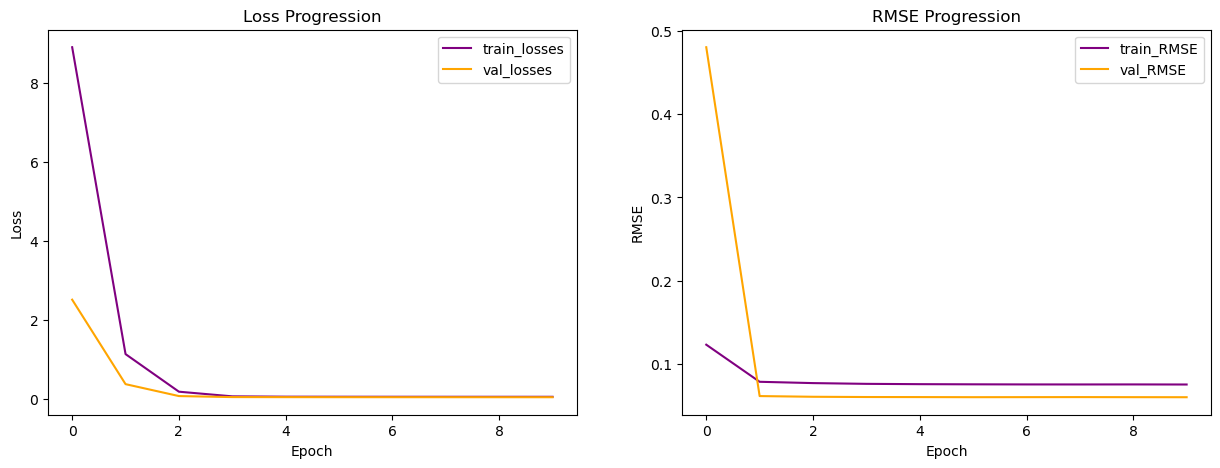

In [17]:
model = build_model(training_features,
                    training_permno,
                    initial_learning_rate=0.00002,
                    decay_steps=1000,
                    decay_rate=0.96,
                    attn_hidden=[256,128,64],
                    embed_hidden=[128,64],
                    hidden=[1024],
                    dropout=0.3)

# get original embeddings
embeddings_untrained = model.get_layer('embeddings').get_weights()[0]

history = model.fit(
   x=[training_permno, training_features],
   y=training_y,
   epochs=10,
   validation_data=(
      [validation_permno, validation_features],
      validation_y
   ),
   batch_size=64,
   callbacks=[callback],
   verbose=1)

# get trained embeddings
embeddings_trained = model.get_layer('embeddings').get_weights()[0]

visualize(history)

# Generate overall predictions & visualize the results

In [18]:
training_prediction = model.predict([training_permno, training_features])
validation_prediction = model.predict([validation_permno, validation_features])

1547/1547 [==============================] - 8s 5ms/step


In [19]:
def visualize_results(y_true, y_pred):
  plt.figure(figsize=(10, 4))

  # Plot the true values
  plt.plot(y_true, label='True Value')
  plt.plot(y_pred, label='Predicted Value')

  # Labels and title
  plt.xlabel('Horizon')
  plt.ylabel('Scaled_Return')
  plt.title('Predictions vs. True Values')
  plt.legend()
  plt.show()

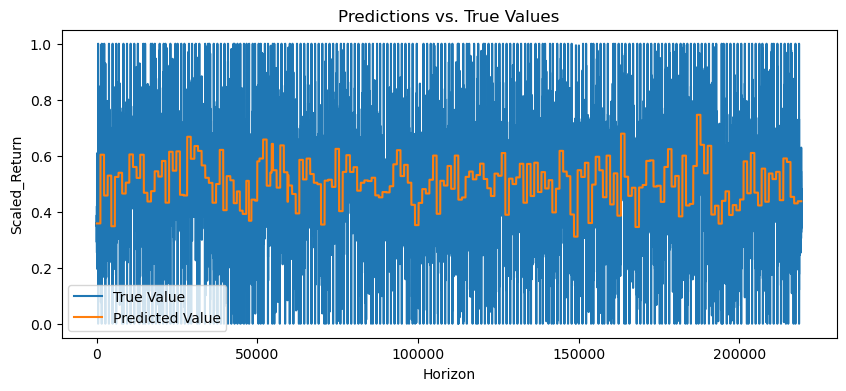

In [20]:
visualize_results(training_y, training_prediction)

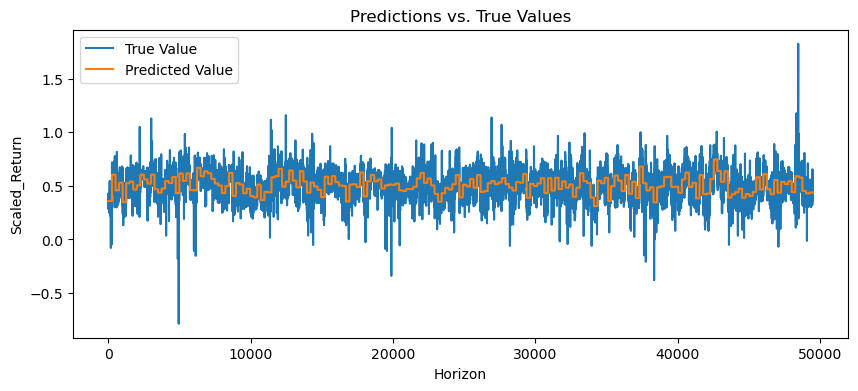

In [21]:
visualize_results(validation_y, validation_prediction)

# Look at the embeddings

In [22]:
embeddings_untrained.shape

(201, 200)

In [23]:
embeddings_untrained[1:][:5]

array([[-3.31971534e-02, -2.78443452e-02, -1.78914666e-02,
        -4.51229326e-02, -4.96834889e-02, -4.85692397e-02,
        -3.57192755e-03, -4.89685684e-03,  7.65465572e-03,
        -1.85775049e-02,  9.72785056e-04, -1.92505121e-02,
        -4.41213958e-02, -4.19686213e-02, -7.12130219e-03,
         3.08064111e-02, -1.59950368e-02,  2.49091648e-02,
        -2.34968551e-02,  2.93852426e-02,  2.17618458e-02,
        -3.11467778e-02, -2.47982629e-02,  1.50158294e-02,
        -1.99148413e-02, -2.54877098e-02,  2.59219147e-02,
        -4.80331108e-03,  3.78543027e-02, -3.91676910e-02,
        -3.64546664e-02,  9.72846895e-03, -5.66544384e-03,
        -7.71087408e-03,  2.63916589e-02, -3.08667775e-02,
        -4.21129093e-02,  6.73531368e-03, -4.96966504e-02,
         3.31299566e-02, -2.80388128e-02,  3.36757042e-02,
         3.01431082e-02,  6.77088648e-03,  3.36749591e-02,
        -2.50276178e-03, -2.85727028e-02,  2.71650292e-02,
         4.58324812e-02,  3.58220451e-02, -4.79125977e-0

In [24]:
embeddings_trained[1:][:5]

array([[-9.87388864e-02, -9.20180082e-02,  3.14161442e-02,
        -1.10899948e-01, -1.15135722e-01,  1.72027126e-02,
         6.20680265e-02,  3.84660698e-02,  5.92280217e-02,
         4.94169071e-02, -6.55644536e-02,  4.83986549e-02,
        -1.10286042e-01, -1.06155887e-01, -7.30333030e-02,
         9.80640128e-02,  4.97851558e-02,  9.23506021e-02,
        -9.24431309e-02, -2.73604728e-02,  8.92119333e-02,
         3.43837738e-02,  4.29229364e-02,  5.15096858e-02,
        -8.27187300e-02, -8.59894678e-02, -4.43584733e-02,
         6.16682842e-02, -2.90585514e-02,  2.87558995e-02,
         3.05417012e-02,  7.03449324e-02, -7.21818432e-02,
         1.86597314e-02,  7.76739717e-02, -9.92922112e-02,
        -1.06410392e-01,  7.45895877e-02,  1.64307244e-02,
        -1.55640794e-02, -9.33495834e-02,  1.01011135e-01,
        -2.72642467e-02,  7.25432709e-02, -3.16289924e-02,
        -6.75406456e-02,  3.84409614e-02,  8.79921690e-02,
        -2.00103894e-02, -3.10386308e-02, -1.15044445e-0

Ignore the 1st embedding element, we have the embeddings corresponding to each permno starting from the 2nd embedding element

# Run cosine similarity on the embeddings

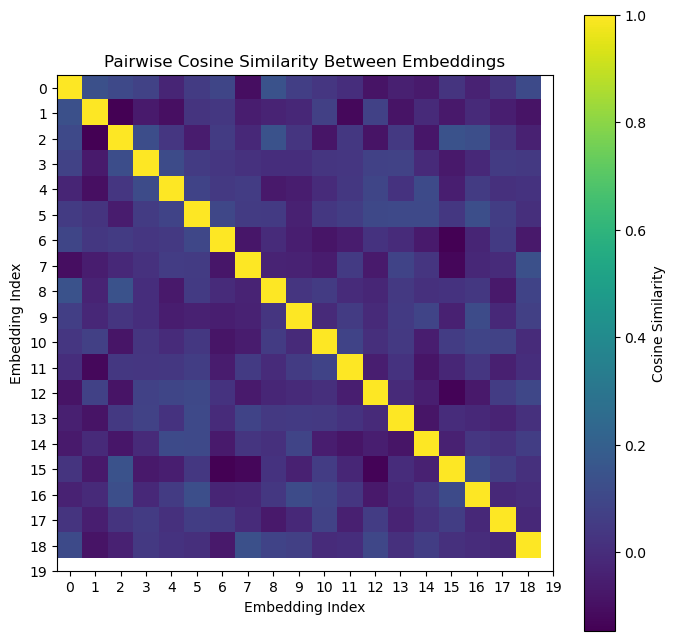

In [33]:
num_permnos = len(np.unique(training_permno))

# Calculate pairwise cosine similarity
cosine_distances = pdist(embeddings_untrained[1:20], metric='cosine')
cosine_similarities = 1 - squareform(cosine_distances)

# Plot the cosine similarity matrix
plt.figure(figsize=(8, 8))
plt.imshow(cosine_similarities, cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title('Pairwise Cosine Similarity Between Embeddings')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.xticks(ticks=np.arange(20), labels=np.arange(20))
plt.yticks(ticks=np.arange(20), labels=np.arange(20))
plt.show()

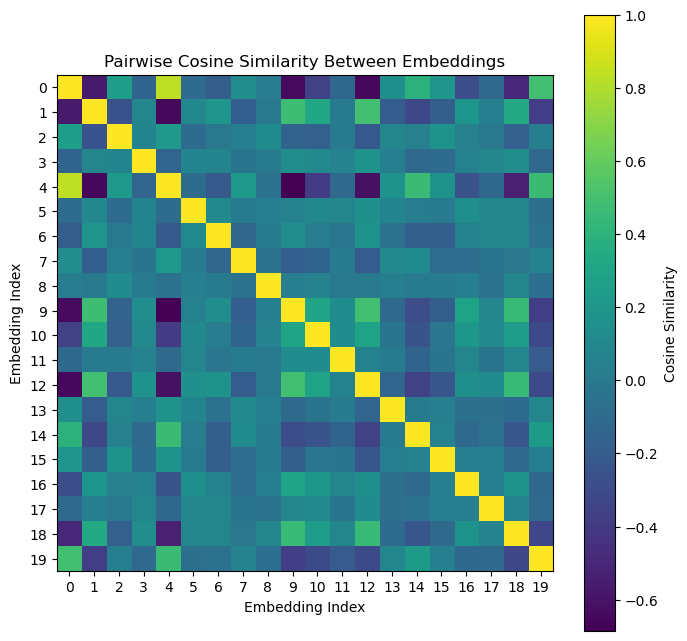

In [34]:
num_permnos = len(np.unique(training_permno))

# Calculate pairwise cosine similarity
cosine_distances = pdist(embeddings_trained[1:21], metric='cosine')
cosine_similarities = 1 - squareform(cosine_distances)

# Plot the cosine similarity matrix
plt.figure(figsize=(8, 8))
plt.imshow(cosine_similarities, cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title('Pairwise Cosine Similarity Between Embeddings')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.xticks(ticks=np.arange(20), labels=np.arange(20))
plt.yticks(ticks=np.arange(20), labels=np.arange(20))
plt.show()

# Sample 5 permnos to visualize the true values vs predictions

In [27]:
visualize_df = pd.DataFrame({'permno_id': training_permno.flatten(),
                             'true_y': training_y.flatten(),
                             'pred_y': training_prediction.flatten()})
visualize_df.head()

,permno_id,true_y,pred_y
0,10104,0.351361,0.358181
1,10104,0.378944,0.358181
2,10104,0.333136,0.358181
3,10104,0.336970,0.358181
4,10104,0.355310,0.358181


-------------------------------------------------- 10104 --------------------------------------------------


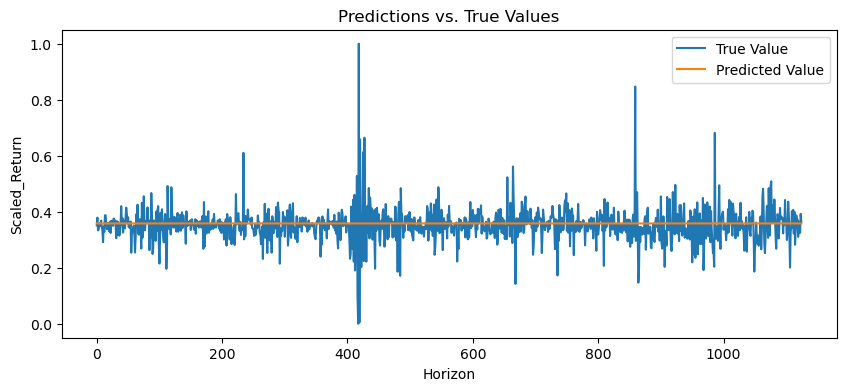


-------------------------------------------------- 11308 --------------------------------------------------


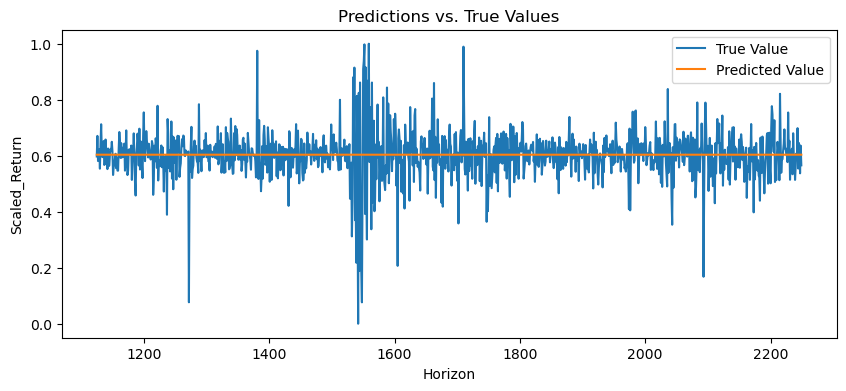


-------------------------------------------------- 11403 --------------------------------------------------


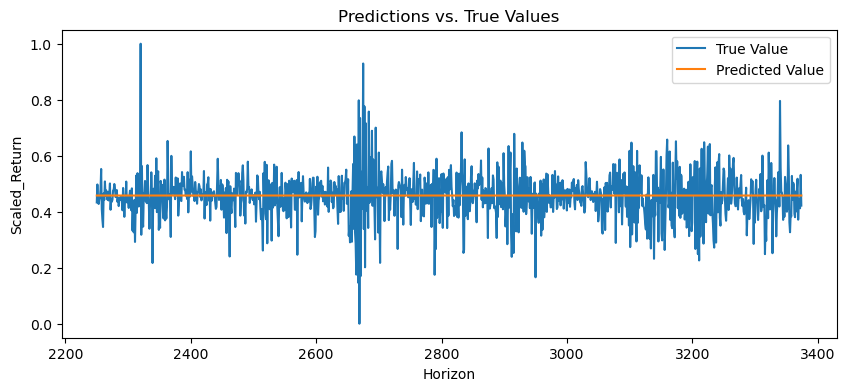


-------------------------------------------------- 11674 --------------------------------------------------


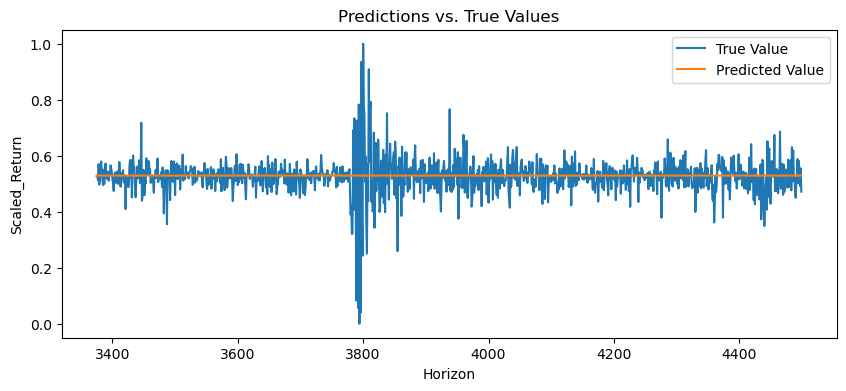


-------------------------------------------------- 11762 --------------------------------------------------


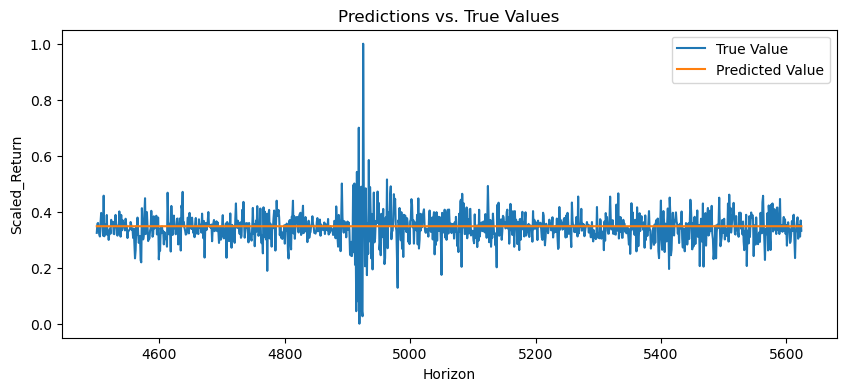

In [28]:
for permno in visualize_df['permno_id'].unique()[:5]:
  print("-"*50, permno, "-"*50)
  visualize_permno = visualize_df[visualize_df['permno_id'] == permno]
  visualize_results(visualize_permno['true_y'], visualize_permno['pred_y'])
  print()

# Save the trained embeddings & calculated cosine similarities to a pkl file

In [29]:
with open('/home/sagemaker-user/capstone-2024-summer/data/crsp_rachel_embedding.pkl', 'wb') as file:
  pickle.dump(embeddings_trained, file)

with open('/home/sagemaker-user/capstone-2024-summer/data/crsp_rachel_cosine.pkl', 'wb') as file:
  pickle.dump(cosine_similarities, file)

In [30]:
with open('/home/sagemaker-user/capstone-2024-summer/data/crsp_rachel_embedding.pkl', 'rb') as file:
  reload_embeddings = pickle.load(file)

with open('/home/sagemaker-user/capstone-2024-summer/data/crsp_rachel_cosine.pkl', 'rb') as file:
  reload_cosine = pickle.load(file)

In [31]:
assert np.array_equal(embeddings_trained, reload_embeddings)
assert np.array_equal(cosine_similarities, reload_cosine)

In [32]:
s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_rachel_embedding.pkl",
    bucket,
    "CRSP/crsp_rachel_embedding.pkl",
)

s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_rachel_cosine.pkl",
    bucket,
    "CRSP/crsp_rachel_cosine.pkl",
)